# Raport – Optimal Transport w przypisywaniu etykiet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## 1. Generowanie danych

Zbiory $A$ i $B$ zostały wygenerowane syntetycznie jako dwuklasowe rozkłady normalne:
- każda klasa miała inną średnią,
- zastosowano wspólną macierz kowariancji dla klas w danym zbiorze, żeby zbiory były porównywalne.


In [2]:
def generate_dataset(n_samples, mean1, mean2, cov, offset=np.array([0.0, 0.0])):
    
    half = n_samples // 2
    X_class1 = np.random.multivariate_normal(mean1, cov, half) + offset
    X_class2 = np.random.multivariate_normal(mean2, cov, half) + offset
    X = np.vstack((X_class1, X_class2))
    y = np.array([0] * half + [1] * half)
    return X, y

### 1.1 Generowanie danych - ciąg dalszy

Wyznaczane jest tu próbkowanie zbiorów $A$ oraz $B$, a także ich średnia wartość oczekiwana i odchylenie standardowe.

In [3]:
def generate_datasets(n_samples_A, n_samples_B, n_dimensions, offset = 0) :

    mean_A1 = np.full(fill_value = 0, shape = n_dimensions)
    mean_A2 = np.full(fill_value = 2, shape = n_dimensions)
    cov_A = np.full(fill_value = 0, shape = (n_dimensions, n_dimensions), dtype=np.float64)
    np.fill_diagonal(cov_A, 0.5)

    mean_B1 = np.full(fill_value = 1, shape = n_dimensions)
    mean_B2 = np.full(fill_value = 4, shape = n_dimensions)
    cov_B = np.full(fill_value = 0.3, shape = (n_dimensions, n_dimensions), dtype=np.float64)
    np.fill_diagonal(cov_B, 1)

    offset_A = np.full(fill_value = 0, shape = n_dimensions)

    offset_B = np.full(fill_value = offset, shape = n_dimensions)

    return generate_dataset(n_samples_A, mean_A1, mean_A2, cov_A, offset_A), generate_dataset(n_samples_B, mean_B1, mean_B2, cov_B, offset_B)


In [4]:
np.random.seed(42)

reg = 6 # for sinkhorn
n_samples_A = 300
n_samples_B = 300

n_dimensions = 20

set_A, set_B = generate_datasets(n_samples_A, n_samples_B, n_dimensions)
X_A, y_A = set_A
X_B, y_B_true = set_B


scaler = StandardScaler()
X_A_scaled = scaler.fit_transform(X_A)
X_B_scaled = scaler.transform(X_B)

pca = PCA(n_components=2)
X_combined = np.vstack((X_A_scaled, X_B_scaled))
X_pca = pca.fit_transform(X_combined)

X_A_pca = X_pca[:len(X_A)]
X_B_pca = X_pca[len(X_A):]

In [5]:
def show_sets(X_A, y_A, X_B) :
    scaler = StandardScaler()
    X_A_scaled = scaler.fit_transform(X_A)
    X_B_scaled = scaler.transform(X_B)

    pca = PCA(n_components=2)
    X_combined = np.vstack((X_A_scaled, X_B_scaled))
    X_pca = pca.fit_transform(X_combined)

    X_A_pca = X_pca[:len(X_A)]
    X_B_pca = X_pca[len(X_A):]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X_A_pca[y_A == 0, 0], X_A_pca[y_A == 0, 1], label='Class 0', alpha=0.7)
    plt.scatter(X_A_pca[y_A == 1, 0], X_A_pca[y_A == 1, 1], label='Class 1', alpha=0.7)
    plt.title("Zbiór A (etykiety znane)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_B_pca[:, 0], X_B_pca[:, 1], color='gray', alpha=0.7)
    plt.title("Zbiór B (etykiety nieznane)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()



Poniżej widzimy, jak układają się wartości klas w zbiorach A oraz B

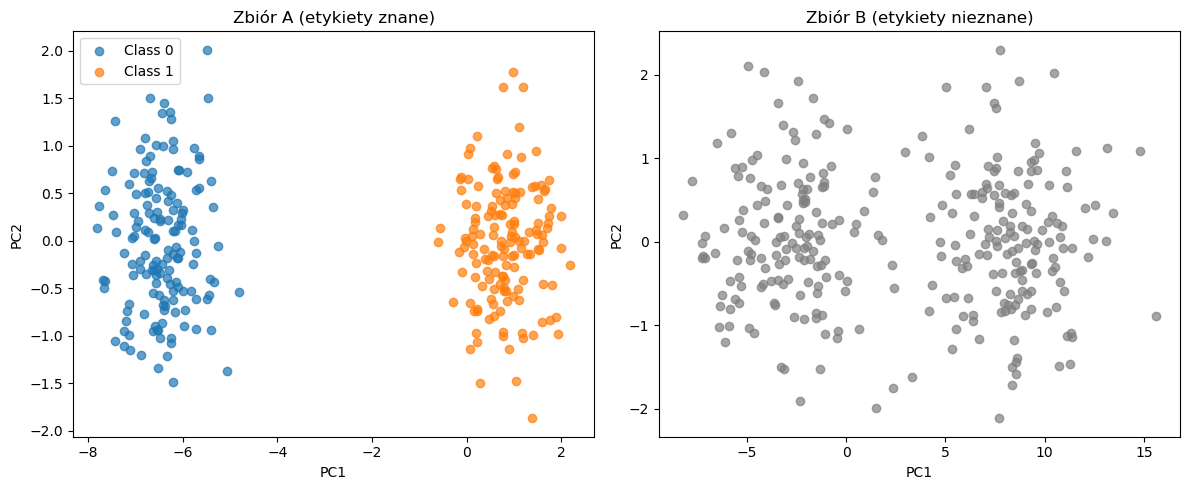

In [6]:
show_sets(X_A, y_A, X_B)

Tutaj ciekawa obserwacja - im więcej wymiarowe są zbiory, tym wyraźniej widać rozgraniczenie między klasami. Powyżej zbiór 20 - wymiarowy, a poniżej 2 - wymiarowy

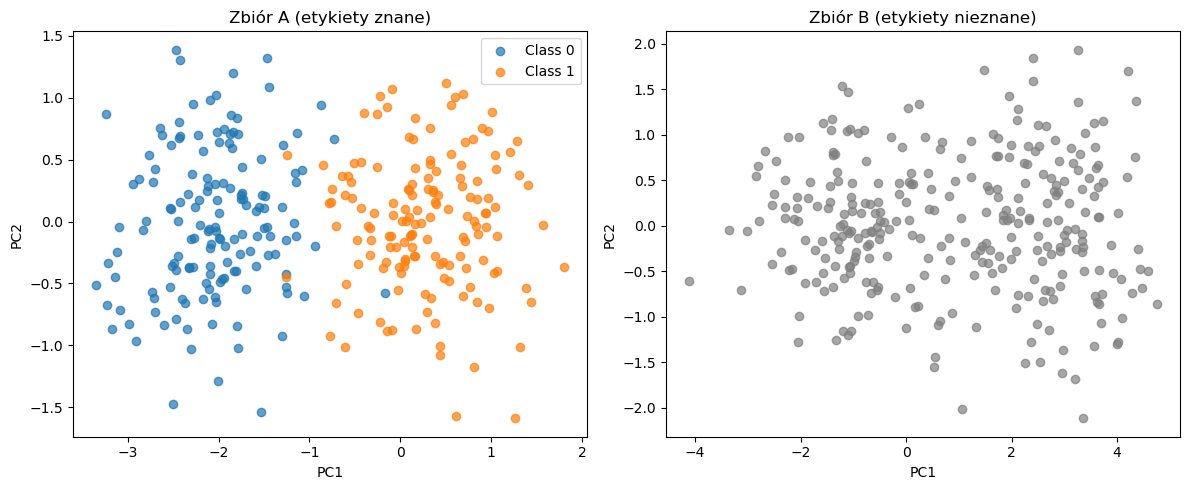

In [7]:

set_A_2, set_B_2 = generate_datasets(n_samples_A, n_samples_B, 2)
X_A_2, y_A_2 = set_A_2
X_B_2, y_B_true_2 = set_B_2
show_sets(X_A_2, y_A_2, X_B_2)
print()

In [8]:
import ot

cost_matrix = ot.dist(X_A_scaled, X_B_scaled)

a = np.ones((X_A_scaled.shape[0],)) / X_A_scaled.shape[0]
b = np.ones((X_B_scaled.shape[0],)) / X_B_scaled.shape[0]

G0 = ot.emd(a, b, cost_matrix)


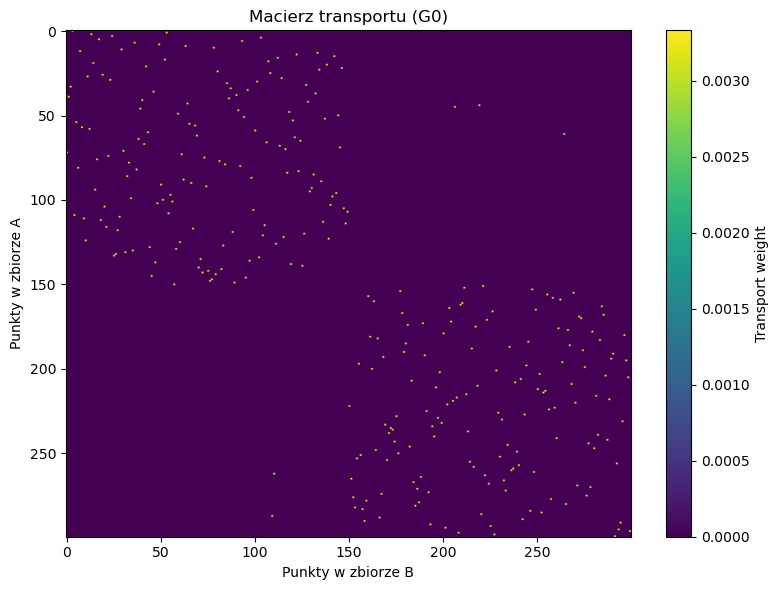

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(G0, aspect='auto', cmap='viridis')
plt.colorbar(label='Transport weight')
plt.title("Macierz transportu (G0)")
plt.xlabel("Punkty w zbiorze B")
plt.ylabel("Punkty w zbiorze A")
plt.tight_layout()
plt.show()

Powyżej macierz transportu. Zauważalnie widać gdzie występowały mody na zbiorze

## 2. Metoda

### 2.1 Transport optymalny

Obliczono macierz kosztów:
$$
M_{i,j} = \| x^A_i - x^B_j \|_2
$$

Użyta miara:  
 - EMD  

Wagi: jednostajny rozkład:
$$
a = \frac{1}{m_1} \cdot \mathbf{1}, \quad b = \frac{1}{m_2} \cdot \mathbf{1}
$$



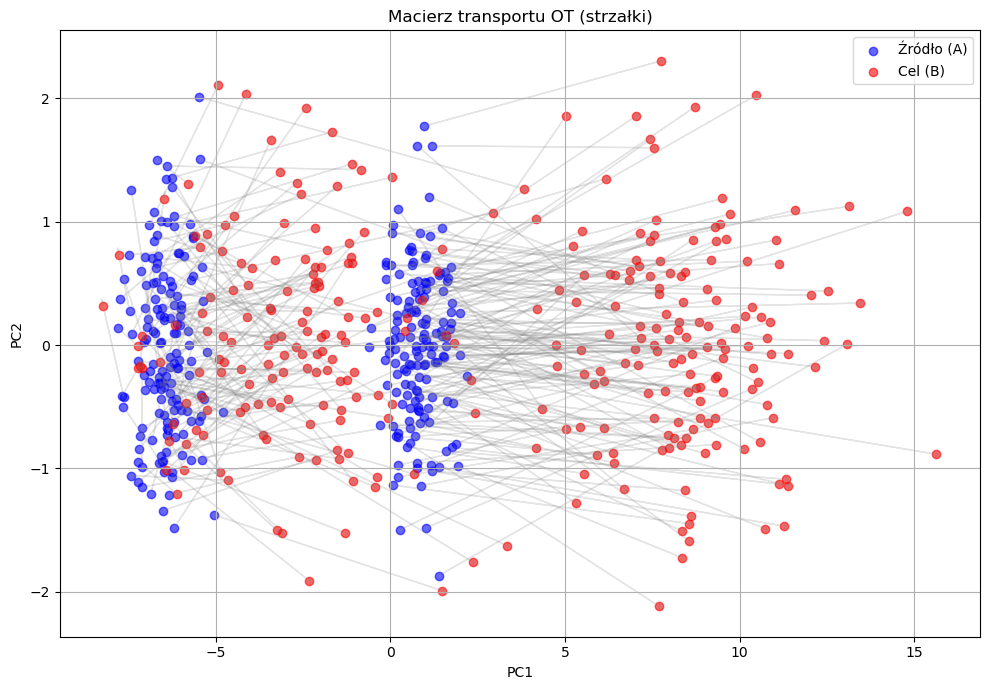

In [10]:
plt.figure(figsize=(10, 7))

plt.scatter(X_A_pca[:, 0], X_A_pca[:, 1], color='blue', label='Źródło (A)', alpha=0.6)
plt.scatter(X_B_pca[:, 0], X_B_pca[:, 1], color='red', label='Cel (B)', alpha=0.6)

for i in range(G0.shape[0]):
    for j in range(G0.shape[1]):
        if G0[i, j] > 1e-3:
            plt.arrow(X_A_pca[i, 0], X_A_pca[i, 1],
                      X_B_pca[j, 0] - X_A_pca[i, 0],
                      X_B_pca[j, 1] - X_A_pca[i, 1],
                      alpha=0.2, color='gray', width=0.0001, head_width=0.05)

plt.title("Macierz transportu OT (strzałki)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 2.2 Przypisywanie etykiet

Dla każdego punktu $ x_j^B $, przypisano etykietę:
$$
y_j^B = \arg\max_{c \in \{0,1\}} \sum_{i \in A_c} G_{i,j}
$$
gdzie $ G $ to macierz transportu, a $ A_c $ to punkty ze zbioru $ A $ należące do klasy $ c $.


Tutaj "notacja strzałkowa" na zbiorach - pokazuje odwzorowanie (na tych próbkach mamy odwzorowanie 1:1) etykiet ze zbioru A do zbioru B

In [11]:
y_B_pred = np.zeros(X_B_scaled.shape[0], dtype=int)

for j in range(G0.shape[1]):
    mass_from_class_0 = np.sum(G0[y_A == 0, j])
    mass_from_class_1 = np.sum(G0[y_A == 1, j])
    
    y_B_pred[j] = 0 if mass_from_class_0 > mass_from_class_1 else 1


Dokładność przypisanych etykiet w zbiorze B: 98.00%


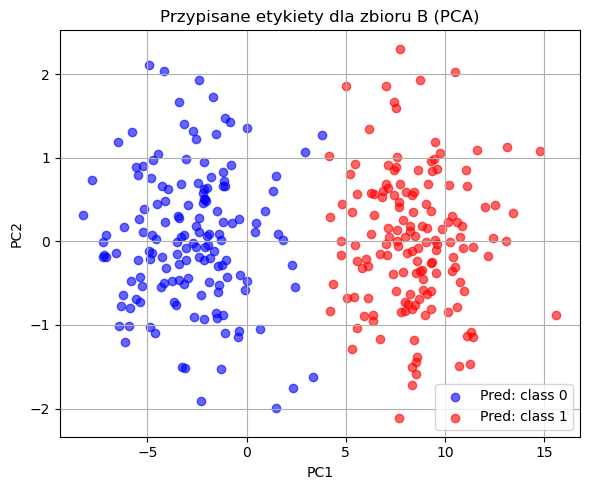

In [12]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_B_true, y_B_pred)
print(f"Dokładność przypisanych etykiet w zbiorze B: {accuracy:.2%}")

plt.figure(figsize=(6, 5))
plt.scatter(X_B_pca[y_B_pred == 0, 0], X_B_pca[y_B_pred == 0, 1], color='blue', label='Pred: class 0', alpha=0.6)
plt.scatter(X_B_pca[y_B_pred == 1, 0], X_B_pca[y_B_pred == 1, 1], color='red', label='Pred: class 1', alpha=0.6)
plt.title("Przypisane etykiety dla zbioru B (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from collections import defaultdict

def run_experiment(n_samples_A, n_samples_B, n_dimensions = n_dimensions, use_sinkhorn = True):
    
    set_A, set_B = generate_datasets(n_samples_A, n_samples_B, n_dimensions)
    X_A, y_A = set_A

    X_B, y_B_true = set_B

    scaler = StandardScaler()
    X_A_scaled = scaler.fit_transform(X_A)
    X_B_scaled = scaler.transform(X_B)

    a = np.ones((X_A_scaled.shape[0],)) / X_A_scaled.shape[0]
    b = np.ones((X_B_scaled.shape[0],)) / X_B_scaled.shape[0]
    cost_matrix = ot.dist(X_A_scaled, X_B_scaled)
    G0 = None
    if use_sinkhorn :
        G0 = ot.sinkhorn(a, b, cost_matrix, reg)
    else :
        G0 = ot.emd(a, b, cost_matrix)
    y_B_pred = np.zeros(X_B_scaled.shape[0], dtype=int)
    for j in range(G0.shape[1]):
        mass_from_0 = np.sum(G0[y_A == 0, j])
        mass_from_1 = np.sum(G0[y_A == 1, j])
        y_B_pred[j] = 0 if mass_from_0 > mass_from_1 else 1

    return accuracy_score(y_B_true, y_B_pred)

cases = [
    (300, 100),
    (100, 300),
    (300, 300),
]

results = defaultdict(float)

for m1, m2 in cases:
    acc = run_experiment(m1, m2)
    results[(m1, m2)] = acc
    print(f"A: {m1}, B: {m2} → Accuracy: {acc:.2%}")


A: 300, B: 100 → Accuracy: 100.00%
A: 100, B: 300 → Accuracy: 99.67%
A: 300, B: 300 → Accuracy: 99.33%


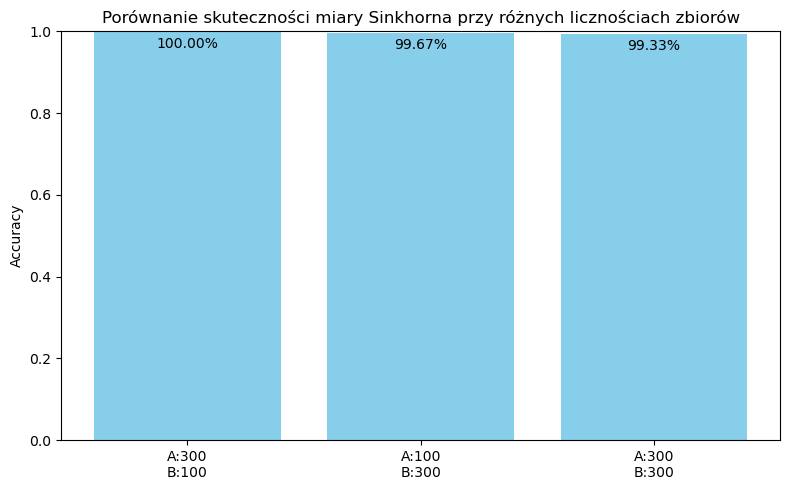

In [14]:
labels = [f"A:{m1}\nB:{m2}" for (m1, m2) in results.keys()]
accuracies = [results[key] for key in results.keys()]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Porównanie skuteczności miary Sinkhorna przy różnych licznościach zbiorów")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, (yval + 0.02) if yval <= 0.5 else yval - 0.04, f"{yval:.2%}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Użyta miara : Sinkhorn (reg ustawione na 6, mimo że oryginalnie miało być 0.05, ale ciągle miałem błędy dotyczące tego, że miara była niezbieżna)  

## 3. Wpływ liczności zbiorów na dokładność

Porównano dokładności dla:

| m₁ (A) | m₂ (B) | Dokładność |
|--------|--------|------------|
| 300    | 100    | 100.00 %   |
| 100    | 300    | 99.67 %    |
| 300    | 300    | 99.33 %    |

Dla takich liczności zbiorów nie widać specjalnej różnicy, jednak sprowadza się ona do poniższego wniosku, który lepiej widoczny będzie na wykresie poniżej

Im większy jest stosunek wartości $\frac{m₁}{m₂}$ tym większa jest dokładność - ma to sens, ponieważ wiemy o wiele więcej o zbiorze A niż o zbiorze B, więc jesteśmy w stanie dokładniej przepisywac etykiety


---

### Skuteczność miary Sinkhorna zależnie od wymiarowości

Function 0 to przypadek dla miar zbiorów A -> 300 B -> 100  
Function 1 to przypadek dla miar zbiorów A -> 100 B -> 300  
Function 2 to przypadek dla miar zbiorów A -> 300 B -> 300  


In [15]:
def plot_data(x, y_values, title = "") :
    y_values = np.array(y_values)
    for i in range(y_values.shape[1]) :
        plt.plot(x, y_values[:, i], label = f'Function {i}')
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    plt.show()

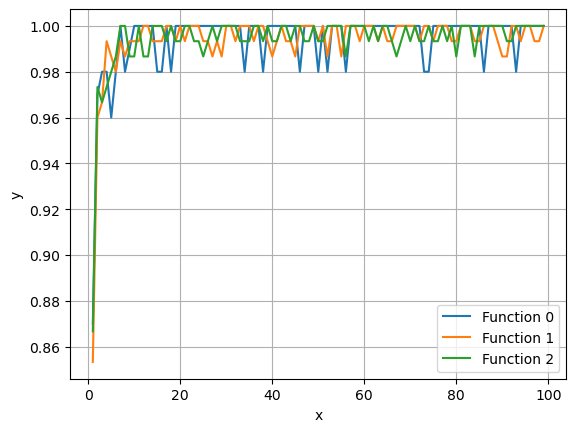

In [16]:
x_s = []
y_s = []

for n in range(1, 100) :
    x_s.append(n)
    current = []
    for m1, m2 in cases :
        current.append(run_experiment(m1, m2, n, False))
    y_s.append(current)

plot_data(x_s, y_s)

Jak widać skuteczność rośnie wraz z wymiarowością zbiorów danych, aczkolwiek zdarzają się jej spadki. Myślę, że można to zrzucić na karb elementu losowego


Dobrym sposobem byłoby też pokazanie czterowymiarowo wartości skuteczności w zależności od liczności zbiorów, wymiarowości danych, oraz reprezentatywności zbiorów, aczkolwiek ciężko jest pokazywać funkcje czterowymiarowe inaczej niż na 3-wymiarowej mapie ciepła, a nie wiem jak ją stworzyć

---

# Podsumowanie

## 1. Generowanie danych

Zbiory A i B zostały wygenerowane syntetycznie jako dwuklasowe rozkłady normalne:
- każda klasa miała inną średnią,
- zastosowano wspólną macierz kowariancji dla klas w danym zbiorze, żeby zbiory były porównywalne.

---

## 2. Metoda

### 2.1 Transport optymalny

Obliczono macierz kosztów:
$$
M_{i,j} = \| x^A_i - x^B_j \|_2
$$

Użyta miara:  
   - Za pierwszym razem :  
     - EMD  
   - Do wszystkich innych pomiarów :  
     - Sinkhorn (reg ustawione na 6, mimo że oryginalnie miało być 0.05, ale ciągle miałem błędy dotyczące tego, że miara była niezbieżna)  

Wagi: jednostajny rozkład:
$$
a = \frac{1}{m_1} \cdot \mathbf{1}, \quad b = \frac{1}{m_2} \cdot \mathbf{1}
$$

### 2.2 Przypisywanie etykiet

Dla każdego punktu $ x_j^B $, przypisano etykietę:
$$
y_j^B = \arg\max_{c \in \{0,1\}} \sum_{i \in A_c} G_{i,j}
$$
gdzie $ G $ to macierz transportu, a $ A_c $ to punkty ze zbioru $ A $ należące do klasy $ c $.

---

## 3. Wpływ liczności zbiorów na dokładność

Porównano dokładności dla:

| m₁ (A) | m₂ (B) | Dokładność |
|--------|--------|------------|
| 300    | 100    | 100.00 %   |
| 100    | 300    | 99.67 %    |
| 300    | 300    | 99.33 %    |

Jak widać, im większy jest stosunek wartości $\frac{m₁}{m₂}$ tym większa jest dokładność - ma to sens, ponieważ wiemy o wiele więcej o zbiorze A niż o zbiorze B, więc jesteśmy w stanie dokładniej przepisywac etykiety

---

## 5. Wnioski końcowe

- Transport optymalny umożliwia skuteczne przypisywanie etykiet bez nadzoru, nawet przy różnicy rozkładów.
- Jakość zależy od:
  - liczności i reprezentatywności zbioru A
  - zgodności rozkładów klas w A i B
  - wymiarowości zbiorów

